In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

pd.options.display.float_format='{:.2f}'.format

# machine learning using ComplementNB

## Step 0: data cleaning

### data loading

In [2]:
data = pd.read_csv("data.csv")
backup = data.copy()

### data discovery

In [3]:
data.dtypes.value_counts()

float64    93
int64       3
Name: count, dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [5]:
# pd.set_option("display.max_rows", 100)

countValues = pd.DataFrame(data.isna().sum(), columns=["value"]).reset_index()
countNull = countValues[countValues["value"] > 0]
countNull

,index,value


### correlation

In [6]:
# import seaborn as sns
# from matplotlib import pyplot as plt
# %matplotlib inline

correlation = data.corr()

# mask = np.zeros_like(correlation, dtype=bool)
# mask[np.triu_indices_from(mask)]= True

# cmap = sns.diverging_palette(180, 180, as_cmap=True)

# plt.figure(figsize=(50,25))
# sns.plot = sns.heatmap(
#     correlation, 
#     mask = mask,
#     cmap = cmap,
#     vmax = .9,
#     center = 0,
#     square = True,
#     linewidths = .5,
#     cbar_kws = {"shrink": .5},
#     annot_kws={"fontsize":6},
#     annot = True, 
#     fmt = ".1f")

### data preparation

In [7]:
upper_tri = correlation.where(np.triu(np.ones(correlation.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
to_drop

[' ROA(A) before interest and % after tax',
 ' ROA(B) before interest and depreciation after tax',
 ' Realized Sales Gross Margin',
 ' Pre-tax net Interest Rate',
 ' After-tax net Interest Rate',
 ' Continuous interest rate (after tax)',
 ' Net Value Per Share (A)',
 ' Net Value Per Share (C)',
 ' Per Share Net profit before tax (Yuan ¥)',
 ' Regular Net Profit Growth Rate',
 ' Operating profit/Paid-in capital',
 ' Net profit before tax/Paid-in capital',
 ' Cash Flow to Sales',
 ' Current Liability to Liability',
 ' Current Liability to Equity',
 ' Net Income to Total Assets',
 ' Gross Profit to Sales',
 ' Liability to Equity']

In [8]:
data = data.drop(columns = to_drop).copy()

### no low variance

In [9]:
lowVariance = data.var().to_frame().sort_values(by = 0)
locate_lowVariance = lowVariance.loc[lowVariance[0] < 0.01].T.columns.tolist()
lowVar = data.drop(columns = locate_lowVariance)

### check outliers

In [10]:
# # original data
# print("ORIGINAL DATA")
# for col in backup.columns:
#     plt.figure(figsize=(6,4))
#     sns.boxplot(backup[col])
#     plt.title(f'Boxplot of {col}')
#     plt.show()

In [11]:
# # no correlation data
# print("NO CORRELATION DATA")
# for col in data.columns:
#     plt.figure(figsize=(6,4))
#     sns.boxplot(data[col])
#     plt.title(f'Boxplot of {col}')
#     plt.show()

In [12]:
# # no low variance data
# print("NO no low variance DATA")
# for col in lowVar.columns:
#     plt.figure(figsize=(6,4))
#     sns.boxplot(lowVar[col])
#     plt.title(f'Boxplot of {col}')
#     plt.show()

## Step 1: Split the data into training and testing sets


We need to split our data into a training set and a testing set. A common split is 80% for training and 20% for testing. This can be done using the `train_test_split` function in `sklearn.model_selection`.

In [13]:
# original data
X_backup = backup.drop(columns="Bankrupt?")
y_backup = backup["Bankrupt?"]

# no correlation data
X_data = data.drop(columns="Bankrupt?")
y_data = data["Bankrupt?"]

# no low variance data
X_lowVar = lowVar.drop(columns="Bankrupt?")
y_lowVar = lowVar["Bankrupt?"]

In [14]:
from sklearn.model_selection import train_test_split

X_train_backup, X_test_backup, y_train_backup, y_test_backup = train_test_split(X_backup, y_backup, test_size=0.2, random_state=42)
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_train_lowVar, X_test_lowVar, y_train_lowVar, y_test_lowVar = train_test_split(X_lowVar, y_lowVar, test_size=0.2, random_state=42)

## Step 2: why scaling our data wasn't necessary

Naive Bayes algorithms like ComplementNB work on the principle of probability, which isn't affected by the scale of the data. So, we don't need to perform scaling here.

Naive Bayes models, including the ComplementNB, often do not require feature scaling. They are not based on distance measures that could be affected by the scale of the features. We can still scale the data if we want, but it's usually not necessary.

## Step 3: Create the ComplementNB model

Next, we need to create an instance of the `ComplementNB` model.

In [15]:
from sklearn.naive_bayes import ComplementNB

model_backup = ComplementNB()
model_data = ComplementNB()
model_lowVar = ComplementNB()

## Step 4: Train the model

We can then fit the model to our training data.

In [16]:
model_backup.fit(X_train_backup, y_train_backup)
model_data.fit(X_train_data, y_train_data)
model_lowVar.fit(X_train_lowVar, y_train_lowVar)

ComplementNB()

## Step 5: Make predictions

Once the model is trained, we can make predictions on the testing data.

In [17]:
y_pred_backup = model_backup.predict(X_test_backup)
y_pred_data = model_data.predict(X_test_data)
y_pred_lowVar = model_lowVar.predict(X_test_lowVar)

## Step 6: Evaluate the model

We can evaluate our model by calculating the accuracy, precision, recall, and F1 score. We can also use a confusion matrix to visualize the performance of our classifier.

In [18]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Backup model
backup_report = classification_report(y_test_backup, y_pred_backup, output_dict=True)
backup_confusion = confusion_matrix(y_test_backup, y_pred_backup)

# Data model
data_report = classification_report(y_test_data, y_pred_data, output_dict=True)
data_confusion = confusion_matrix(y_test_data, y_pred_data)

# LowVar model
lowVar_report = classification_report(y_test_lowVar, y_pred_lowVar, output_dict=True)
lowVar_confusion = confusion_matrix(y_test_lowVar, y_pred_lowVar)

# Convert reports to dataframes
backup_report_df = pd.DataFrame(backup_report).transpose()
data_report_df = pd.DataFrame(data_report).transpose()
lowVar_report_df = pd.DataFrame(lowVar_report).transpose()

# Convert confusion matrices to dataframes
backup_confusion_df = pd.DataFrame(backup_confusion)
data_confusion_df = pd.DataFrame(data_confusion)
lowVar_confusion_df = pd.DataFrame(lowVar_confusion)

# Print the dataframes
print("Backup model report:")
display(backup_report_df)
print("\nBackup model confusion matrix:")
display(backup_confusion_df)

print("\nData model report:")
display(data_report_df)
print("\nData model confusion matrix:")
display(data_confusion_df)

print("\nLowVar model report:")
display(lowVar_report_df)
print("\nLowVar model confusion matrix:")
display(lowVar_confusion_df)


Backup model report:


,precision,recall,f1-score,support
0,0.97,0.77,0.86,1313.00
1,0.06,0.41,0.11,51.00
accuracy,0.75,0.75,0.75,0.75
macro avg,0.52,0.59,0.48,1364.00
weighted avg,0.94,0.75,0.83,1364.00



Backup model confusion matrix:


,0,1
0,1008,305
1,30,21



Data model report:


,precision,recall,f1-score,support
0,0.97,0.77,0.86,1313.00
1,0.06,0.41,0.11,51.00
accuracy,0.75,0.75,0.75,0.75
macro avg,0.52,0.59,0.48,1364.00
weighted avg,0.94,0.75,0.83,1364.00



Data model confusion matrix:


,0,1
0,1008,305
1,30,21



LowVar model report:


,precision,recall,f1-score,support
0,0.97,0.77,0.86,1313.00
1,0.06,0.41,0.11,51.00
accuracy,0.75,0.75,0.75,0.75
macro avg,0.52,0.59,0.48,1364.00
weighted avg,0.94,0.75,0.83,1364.00



LowVar model confusion matrix:


,0,1
0,1008,305
1,30,21


Based on the evaluation results of the data model for predicting bankruptcy, here are some observations:

1. Precision: The precision of the model is 0.97 for class 0 (firm not going into bankruptcy) and 0.06 for class 1 (firm going into bankruptcy). This indicates that the model performs well in predicting non-bankruptcy cases, but has a very low precision for bankruptcy cases. This means that when the model predicts a firm to be bankrupt, it is often incorrect.

2. Recall: The recall (also known as sensitivity or true positive rate) is 0.77 for class 0 and 0.41 for class 1. The recall for class 0 suggests that the model identifies around 77% of the non-bankruptcy cases correctly, while for class 1, it only identifies around 41% of the actual bankruptcy cases.

3. F1-score: The F1-score provides a balance between precision and recall and is the harmonic mean of the two. The F1-score is 0.86 for class 0 and 0.11 for class 1. The low F1-score for class 1 indicates that the model's performance is poor in correctly identifying bankruptcy cases.

4. Accuracy: The overall accuracy of the model is 0.75, which means that it correctly predicts the bankruptcy status of firms in 75% of the cases. However, accuracy alone can be misleading, especially when the classes are imbalanced.

5. Confusion matrix: The confusion matrix shows the predicted labels against the true labels. In this case, the model correctly predicts 1008 non-bankruptcy cases (class 0) and 21 bankruptcy cases (class 1). However, it incorrectly predicts 305 non-bankruptcy cases as bankrupt (false positives) and misses 30 bankruptcy cases (false negatives).

Overall, the data model seems to perform well in predicting non-bankruptcy cases with high precision and recall, but it struggles with correctly identifying bankruptcy cases, as evident from the low precision, recall, and F1-score for class 1. It may be necessary to improve the model's performance by addressing the class imbalance or considering different approaches to handle bankruptcy prediction.

## Step 7: Improve the model

Considering the challenges we're facing with class imbalance and the performance of our current model, here's a suggested order:

**Resampling**
- Since our data is imbalanced, adjusting the balance between classes can often be a good first step. This can help improve model performance by ensuring that the model isn't overwhelmingly exposed to the majority class during training. Techniques like SMOTE or ADASYN can help with this.

**Change the Model or Hyperparameter Tuning**
- Once the data is balanced, we could try different models like decision trees, random forests, or support vector machines, which can sometimes handle imbalanced data more effectively. If we want to continue with ComplementNB, we could look into tuning its hyperparameters. Techniques like GridSearchCV or RandomizedSearchCV can automate the process of finding the best hyperparameters.

**Evaluation Metrics**
- Throughout this process, it's important to use appropriate evaluation metrics. For imbalanced datasets, accuracy is often not the best choice. Instead, consider using metrics like precision, recall, F1-score, and AUC-ROC that give a better understanding of how our model is performing on both the majority and minority classes.


## Step 8: why resampling the data isn't necessary (but still do it anyways)

The Complement Naive Bayes (ComplementNB) classifier is a variant of Naive Bayes designed specifically to correct the severe assumptions made by the standard Multinomial Naive Bayes classifier when dealing with imbalanced data. It is particularly suited for imbalanced data sets because it uses a different form of estimation which makes it more robust to imbalance.

### Step 8.1: Resampling
As our first step towards improving our model, we need to address the class imbalance in our data. Synthetic Minority Over-sampling Technique (SMOTE) can be used to balance out the classes.

In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

# Resample the training data
X_train_resampled_backup, y_train_resampled_backup = smote.fit_resample(X_train_backup, y_train_backup)
X_train_resampled_data, y_train_resampled_data = smote.fit_resample(X_train_data, y_train_data)
X_train_resampled_lowVar, y_train_resampled_lowVar = smote.fit_resample(X_train_lowVar, y_train_lowVar)

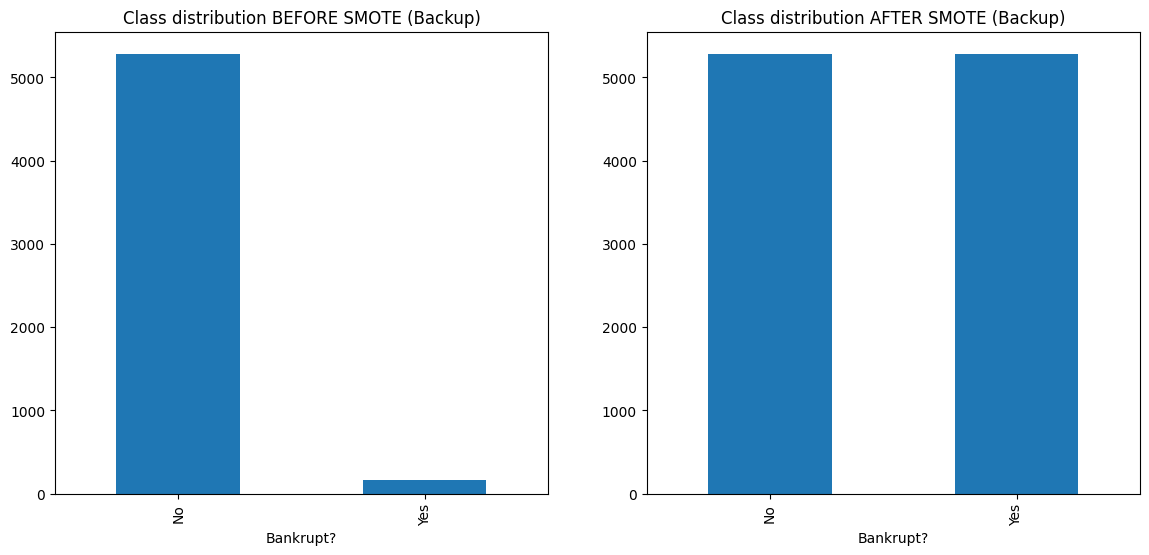

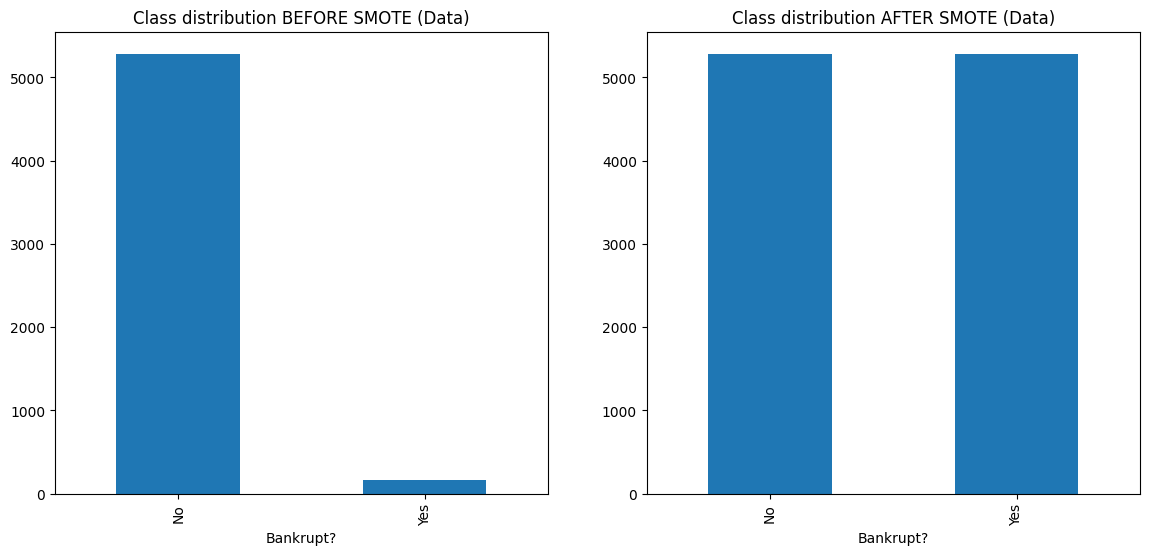

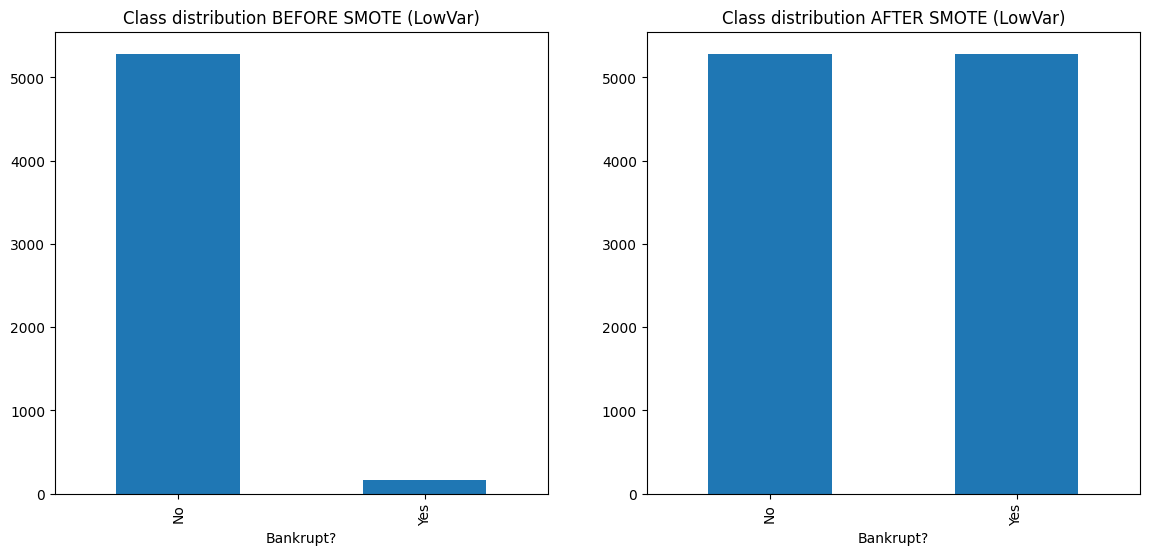

In [20]:
import matplotlib.pyplot as plt

# Plot before resampling
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
y_train_backup.value_counts().plot(kind="bar", title="Class distribution BEFORE SMOTE (Backup)")
plt.xticks([0,1], ["No", "Yes"])

plt.subplot(1,2,2)
y_train_resampled_backup.value_counts().plot(kind="bar", title="Class distribution AFTER SMOTE (Backup)")
plt.xticks([0,1], ["No", "Yes"])

plt.show()

# Plot before resampling for Data
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
y_train_data.value_counts().plot(kind="bar", title="Class distribution BEFORE SMOTE (Data)")
plt.xticks([0,1], ["No", "Yes"])

plt.subplot(1,2,2)
y_train_resampled_data.value_counts().plot(kind="bar", title="Class distribution AFTER SMOTE (Data)")
plt.xticks([0,1], ["No", "Yes"])

plt.show()

# Plot before resampling for LowVar
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
y_train_lowVar.value_counts().plot(kind="bar", title="Class distribution BEFORE SMOTE (LowVar)")
plt.xticks([0,1], ["No", "Yes"])

plt.subplot(1,2,2)
y_train_resampled_lowVar.value_counts().plot(kind="bar", title="Class distribution AFTER SMOTE (LowVar)")
plt.xticks([0,1], ["No", "Yes"])

plt.show()

### Step 8.2: Re-training the Model
After addressing class imbalance through resampling, the next step is to retrain our model using the resampled data.

In [21]:
# Backup model
model_resampled_backup = ComplementNB()
model_resampled_backup.fit(X_train_resampled_backup, y_train_resampled_backup)

# No correlation data model
model_resampled_data = ComplementNB()
model_resampled_data.fit(X_train_resampled_data, y_train_resampled_data)

# No low variance data model
model_resampled_lowVar = ComplementNB()
model_resampled_lowVar.fit(X_train_resampled_lowVar, y_train_resampled_lowVar)

ComplementNB()

### Step 8.3: Predictions
Next, we make predictions using the re-trained model.

In [22]:
# Backup model predictions
y_pred_resampled_backup = model_resampled_backup.predict(X_test_backup)

# No correlation data model predictions
y_pred_resampled_data = model_resampled_data.predict(X_test_data)

# No low variance data model predictions
y_pred_resampled_lowVar = model_resampled_lowVar.predict(X_test_lowVar)

### Step 8.4: Evaluate the Model
After re-training the model and making predictions, we need to evaluate the model's performance again.

In [23]:
from sklearn.metrics import classification_report

# Convert classification report into a DataFrame
report_backup = classification_report(y_test_backup, y_pred_resampled_backup, output_dict=True)
report_data = classification_report(y_test_data, y_pred_resampled_data, output_dict=True)
report_lowVar = classification_report(y_test_lowVar, y_pred_resampled_lowVar, output_dict=True)

df_classification_report_backup = pd.DataFrame(report_backup).transpose()
df_classification_report_data = pd.DataFrame(report_data).transpose()
df_classification_report_lowVar = pd.DataFrame(report_lowVar).transpose()

# Display classification reports
print("Resampled Backup model classification report:")
display(df_classification_report_backup)

print("\nResampled Data model classification report:")
display(df_classification_report_data)

print("\nResampled LowVar model classification report:")
display(df_classification_report_lowVar)

# Convert confusion matrix into a DataFrame
from sklearn.metrics import confusion_matrix

conf_mat_backup = confusion_matrix(y_test_backup, y_pred_resampled_backup)
conf_mat_data = confusion_matrix(y_test_data, y_pred_resampled_data)
conf_mat_lowVar = confusion_matrix(y_test_lowVar, y_pred_resampled_lowVar)

df_conf_mat_backup = pd.DataFrame(conf_mat_backup, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])
df_conf_mat_data = pd.DataFrame(conf_mat_data, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])
df_conf_mat_lowVar = pd.DataFrame(conf_mat_lowVar, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

# Display confusion matrices
print("\nResampled Backup model confusion matrix:")
display(df_conf_mat_backup)

print("\nResampled Data model confusion matrix:")
display(df_conf_mat_data)

print("\nResampled LowVar model confusion matrix:")
display(df_conf_mat_lowVar)

Resampled Backup model classification report:


,precision,recall,f1-score,support
0,0.97,0.71,0.82,1313.00
1,0.06,0.47,0.11,51.00
accuracy,0.70,0.70,0.70,0.70
macro avg,0.52,0.59,0.46,1364.00
weighted avg,0.94,0.70,0.79,1364.00



Resampled Data model classification report:


,precision,recall,f1-score,support
0,0.97,0.71,0.82,1313.00
1,0.06,0.47,0.11,51.00
accuracy,0.70,0.70,0.70,0.70
macro avg,0.52,0.59,0.46,1364.00
weighted avg,0.94,0.70,0.79,1364.00



Resampled LowVar model classification report:


,precision,recall,f1-score,support
0,0.97,0.71,0.82,1313.00
1,0.06,0.47,0.11,51.00
accuracy,0.70,0.70,0.70,0.70
macro avg,0.52,0.59,0.46,1364.00
weighted avg,0.94,0.70,0.79,1364.00



Resampled Backup model confusion matrix:


,Predicted Negative,Predicted Positive
Actual Negative,934,379
Actual Positive,27,24



Resampled Data model confusion matrix:


,Predicted Negative,Predicted Positive
Actual Negative,934,379
Actual Positive,27,24



Resampled LowVar model confusion matrix:


,Predicted Negative,Predicted Positive
Actual Negative,934,379
Actual Positive,27,24


Given that the data is imbalanced with a minority positive class (Bankrupt), from a business perspective, it's essential to focus on the precision, recall, and F1-score for the positive class rather than the accuracy metric.

The evaluation metrics show that the recall of the minority/positive class (bankrupt companies) has improved substantially after resampling, which is a good sign (moving from 0.41 to 0.47). This means that our resampled model is better at identifying the positive instances, which, from a business perspective, might be more important as we are more interested in correctly identifying companies that are likely to go bankrupt. This is confirmed by the confusion matrix where our model's true positive rate has increased.

However, there's a trade-off between precision and recall for the minority class. The precision of the minority class has decreased (0.06), meaning that among all instances that our model has predicted as positive, fewer are actually positive. Similarly, the F1-score for the positive class is still low (0.11), suggesting that there is a lot of room for improvement. This is reflected in an increase of false positives (Predicted Positive and Actual Negative in the confusion matrix).

Comparing these results with the previous ones, resampling has helped us better identify bankrupt companies at the cost of increasing the number of false alarms. Overall, our model's performance can be considered improved if our primary concern was improving recall for the minority class.

Given these results, I would suggest that our model's performance is not yet satisfactory. Further steps such as hyperparameter tuning or trying out different models could be taken to improve our model's performance. Also, considering the importance of recall for this business case, you might want to tune the model in such a way that it leans more towards improving recall, even if it's at the expense of precision.

_**PRESENTATION SPEECH**_

Looking at the data, we see it's not balanced - there are fewer 'Bankrupt' cases. For our business, it's important to look at the precision, recall, and F1-score of these 'Bankrupt' cases, instead of just accuracy.

When we check how the model is doing, we see that it's getting better at picking up 'Bankrupt' cases after we resample the data (the recall went up from 0.41 to 0.47). This means our resampled model is getting better at finding these cases. For our business, we want to spot companies that might go bankrupt correctly. The model is doing this better now, as we can see in the confusion matrix, where the true positive rate has gone up.

But, there's a balance between precision and recall for the 'Bankrupt' cases. Precision has gone down a bit (to 0.06). This means that, of all the cases the model flagged as 'Bankrupt', fewer of them really are. The F1-score for 'Bankrupt' cases is also still low (0.11), showing we still have work to do. We can see this in the confusion matrix, where the number of false positives (the model said 'Bankrupt' but it's not) has gone up.

When we compare these results with the old ones, resampling helped us find bankrupt companies better, but we also got more false alarms. If improving recall for 'Bankrupt' cases was our main concern, we could say the model is doing better.

But based on these results, I'd say the model isn't doing well enough yet. We could take more steps like adjusting settings or trying different models to make the performance better. Since recall is really important for our business case, we might want to adjust the model so it gets even better at recall, even if precision drops a bit.

## Step 9: Hyperparameter Tuning

We will use GridSearchCV for this purpose. We'll tune the alpha parameter, which is a smoothing parameter.

For ComplementNB, the smoothing priors alpha >= 0 accounts for features not present in the learning samples and prevents zero probabilities in further computations. Setting alpha = 1 is called Laplace smoothing, while alpha < 1 is called Lidstone smoothing.

In [24]:
from sklearn.model_selection import GridSearchCV

# Define the parameter values that should be searched
alpha_list = [0.001, 0.01, 0.1, 0.5, 1, 10]

# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = {'alpha': alpha_list}

# Instantiate the grid
grid = GridSearchCV(ComplementNB(), param_grid, cv=10, scoring='recall')

# Fit the grid with data 
grid.fit(X_train_resampled_backup, y_train_resampled_backup)

# View the complete results
print("Best parameters for Backup model: ", grid.best_params_)
print("Best score for Backup model: ", grid.best_score_)

grid.fit(X_train_resampled_data, y_train_resampled_data)
print("Best parameters for Data model: ", grid.best_params_)
print("Best score for Data model: ", grid.best_score_)

grid.fit(X_train_resampled_lowVar, y_train_resampled_lowVar)
print("Best parameters for LowVar model: ", grid.best_params_)
print("Best score for LowVar model: ", grid.best_score_)

Best parameters for Backup model:  {'alpha': 0.001}
Best score for Backup model:  0.4771091109583548
Best parameters for Data model:  {'alpha': 0.001}
Best score for Data model:  0.4771091109583548
Best parameters for LowVar model:  {'alpha': 0.001}
Best score for LowVar model:  0.4771091109583548


This code will run 10-fold cross-validation for each alpha value specified, training and testing the model each time, and it will output the alpha value that got the best recall score.

Remember, we choose 'recall' as the scoring parameter here because we've mentioned it's more important for the business problem at hand.

Once we've got the best alpha values, we can build new ComplementNB models using these alpha values and check if performance has improved.

### Step 9.1: Retrain our models using the optimal alpha parameter found from GridSearchCV and evaluate them again

In [25]:
# Backup model
model_tuned_backup = ComplementNB(alpha=0.001)
model_tuned_backup.fit(X_train_resampled_backup, y_train_resampled_backup)

# No correlation data model
model_tuned_data = ComplementNB(alpha=0.001)
model_tuned_data.fit(X_train_resampled_data, y_train_resampled_data)

# No low variance data model
model_tuned_lowVar = ComplementNB(alpha=0.001)
model_tuned_lowVar.fit(X_train_resampled_lowVar, y_train_resampled_lowVar)

ComplementNB(alpha=0.001)

### Step 9.2: Predictions

In [26]:
# Backup model predictions
y_pred_tuned_backup = model_tuned_backup.predict(X_test_backup)

# No correlation data model predictions
y_pred_tuned_data = model_tuned_data.predict(X_test_data)

# No low variance data model predictions
y_pred_tuned_lowVar = model_tuned_lowVar.predict(X_test_lowVar)

### Step 9.3: Evaluate the model

In [27]:
from sklearn.metrics import classification_report

# Convert classification report into a DataFrame
report_tuned_backup = classification_report(y_test_backup, y_pred_tuned_backup, output_dict=True)
report_tuned_data = classification_report(y_test_data, y_pred_tuned_data, output_dict=True)
report_tuned_lowVar = classification_report(y_test_lowVar, y_pred_tuned_lowVar, output_dict=True)

df_classification_report_tuned_backup = pd.DataFrame(report_tuned_backup).transpose()
df_classification_report_tuned_data = pd.DataFrame(report_tuned_data).transpose()
df_classification_report_tuned_lowVar = pd.DataFrame(report_tuned_lowVar).transpose()

# Display classification reports
print("Tuned Backup model classification report:")
display(df_classification_report_tuned_backup)

print("\nTuned Data model classification report:")
display(df_classification_report_tuned_data)

print("\nTuned LowVar model classification report:")
display(df_classification_report_tuned_lowVar)

Tuned Backup model classification report:


,precision,recall,f1-score,support
0,0.97,0.71,0.82,1313.00
1,0.06,0.47,0.11,51.00
accuracy,0.70,0.70,0.70,0.70
macro avg,0.52,0.59,0.46,1364.00
weighted avg,0.94,0.70,0.79,1364.00



Tuned Data model classification report:


,precision,recall,f1-score,support
0,0.97,0.71,0.82,1313.00
1,0.06,0.47,0.11,51.00
accuracy,0.70,0.70,0.70,0.70
macro avg,0.52,0.59,0.46,1364.00
weighted avg,0.94,0.70,0.79,1364.00



Tuned LowVar model classification report:


,precision,recall,f1-score,support
0,0.97,0.71,0.82,1313.00
1,0.06,0.47,0.11,51.00
accuracy,0.70,0.70,0.70,0.70
macro avg,0.52,0.59,0.46,1364.00
weighted avg,0.94,0.70,0.79,1364.00


In [28]:
# Convert confusion matrix into a DataFrame
from sklearn.metrics import confusion_matrix

conf_mat_tuned_backup = confusion_matrix(y_test_backup, y_pred_tuned_backup)
conf_mat_tuned_data = confusion_matrix(y_test_data, y_pred_tuned_data)
conf_mat_tuned_lowVar = confusion_matrix(y_test_lowVar, y_pred_tuned_lowVar)

df_conf_mat_tuned_backup = pd.DataFrame(conf_mat_tuned_backup, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])
df_conf_mat_tuned_data = pd.DataFrame(conf_mat_tuned_data, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])
df_conf_mat_tuned_lowVar = pd.DataFrame(conf_mat_tuned_lowVar, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

# Display confusion matrices
print("\nTuned Backup model confusion matrix:")
display(df_conf_mat_tuned_backup)

print("\nTuned Data model confusion matrix:")
display(df_conf_mat_tuned_data)

print("\nTuned LowVar model confusion matrix:")
display(df_conf_mat_tuned_lowVar)


Tuned Backup model confusion matrix:


,Predicted Negative,Predicted Positive
Actual Negative,934,379
Actual Positive,27,24



Tuned Data model confusion matrix:


,Predicted Negative,Predicted Positive
Actual Negative,934,379
Actual Positive,27,24



Tuned LowVar model confusion matrix:


,Predicted Negative,Predicted Positive
Actual Negative,934,379
Actual Positive,27,24


First, let's clarify what precision, recall, and F1-score signify:

- Precision: Out of all the predicted positive instances, how many were correctly predicted. A higher precision means fewer false positives.
- Recall: Out of all the actual positive instances, how many were correctly predicted. A higher recall means fewer false negatives.
- F1-score: A balanced measure that considers both precision and recall. The F1 score is the harmonic mean of precision and recall.

The goal here is to improve recall, specifically for the '1' class, which represents bankruptcy. A higher recall for the '1' class means we correctly identify a higher percentage of bankrupt firms, which is very important in this context.

Let's compare the recall of the '1' class:

- Base ComplementNB Model: Recall for the '1' class is 0.41.
- After SMOTE: Recall for the '1' class is 0.47.
- After Hyperparameter Tuning: Recall for the '1' class is 0.47.

So, both SMOTE resampling and hyperparameter tuning improved the recall of the '1' class compared to our base model. Both methods achieved a recall of 0.47, which is higher than our base model's recall of 0.41.

However, the precision and F1-score for the '1' class are still quite low in all scenarios (0.06 precision and 0.11 F1-score), which indicates that there's still a high number of false positives and an imbalance between precision and recall.

Looking at the confusion matrix, we can see that false negatives (bankrupt companies incorrectly predicted as non-bankrupt) have been reduced after SMOTE and hyperparameter tuning, which is good as our goal is to identify bankrupt companies. However, false positives (non-bankrupt companies incorrectly predicted as bankrupt) have increased.

It's worth noting that these metrics should be evaluated in the context of the business problem. If missing a bankrupt company (false negative) is more costly than misclassifying a healthy company (false positive), a higher recall for the '1' class would be beneficial. But the trade-off is that we end up incorrectly classifying more non-bankrupt companies.

In conclusion, SMOTE resampling and hyperparameter tuning managed to improve the recall as per our goal. But the low precision and F1-score indicate that there might be room for further improvement, possibly by trying different resampling methods, using a different algorithm, or further tuning the model parameters.